Note due to technical issues in the desktop anaconda environment, this notebook was trained on Kaggle. 

In [2]:
!pip install livelossplot

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential, load_model
from livelossplot import PlotLossesKeras
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
import pickle

# Preprocessing

## Import datasets

In [4]:
#original complete data, cleaned

traincomplete = pd.read_csv("../input/gene-expression-final/traindata.csv")
testcomplete = pd.read_csv("../input/gene-expression-final/testdata.csv")

#feature selection data

trainfeatureselection = pd.read_csv("../input/gene-expression-final/train.csv")
testfeatureselection = pd.read_csv("../input/gene-expression-final/test.csv")

#LDA
trainlda = pd.read_csv("../input/gene-expression-final/trainlda.csv")
testlda = pd.read_csv("../input/gene-expression-final/testlda.csv")

traincomplete.set_index("sample_id", inplace = True)
testcomplete.set_index("sample_id", inplace = True)

trainfeatureselection.set_index("sample_id", inplace = True)
testfeatureselection.set_index("sample_id", inplace = True)

In [5]:
Xtraincomplete = traincomplete.drop(columns=['Class'])
Xtestcomplete = testcomplete.drop(columns = ['Class'])

labelsTrain = traincomplete['Class']
labelsTest = testcomplete['Class']

Xtrainfeature = trainfeatureselection.drop(columns=['Class'])
Xtestfeature = testfeatureselection.drop(columns=['Class'])

Xtrainlda = trainlda.drop(columns=['Class'])
Xtestlda = testlda.drop(columns=['Class'])

In [6]:
scores_df = pd.read_csv("../input/gene-expression-final/results.csv")

In [7]:
def add_to_df(model_family,dataset_name,roc_score, best_params):
    global scores_df
    dic = {"Model Family": [model_family], "Dataset" : [dataset_name], "ROC_AUC_SCORE" :[roc_score], 
           "Best Params":[best_params]}
    df = pd.DataFrame(dic)
    scores_df = pd.concat([scores_df,df],axis=0,)

## Train - Validation Split

Split the imported training set into training and validation sets for cross validation

In [12]:
random_state = 10

In [13]:
X_train_complete,X_val_complete, y_train_complete, y_val_complete = train_test_split(Xtraincomplete,labelsTrain,
                                                                                      test_size=0.2, 
                                                                                      random_state=random_state, 
                                                                                      stratify= labelsTrain)
X_train_feature, X_val_feature, y_train_feature, y_val_feature = train_test_split(Xtrainfeature,labelsTrain,
                                                                                      test_size=0.2, 
                                                                                      random_state=random_state, 
                                                                                      stratify= labelsTrain)
X_train_dim, X_val_dim, y_train_dim, y_val_dim = train_test_split(Xtrainlda,labelsTrain,test_size=0.2, 
                                                                                      random_state=random_state, 
                                                                                      stratify= labelsTrain)

## Standardize

In [8]:
def standardize(train,val,test):
    std = StandardScaler()
    Xtrain = std.fit_transform(train)
    Xval = std.transform(val)
    Xtest = std.transform(test)
    return Xtrain, Xval, Xtest

In [14]:
X_train_complete_std, X_val_complete_std, X_test_complete_std = standardize(X_train_complete, X_val_complete,
                                                                            Xtestcomplete)

X_train_feature_std, X_val_feature_std, X_test_feature_std = standardize(X_train_feature, X_val_feature, 
                                                                         Xtestfeature)

## Binarize Target variables

In [15]:
y_train_complete = np_utils.to_categorical(y_train_complete)
y_val_complete = np_utils.to_categorical(y_val_complete)
y_train_feature = np_utils.to_categorical(y_train_feature)
y_val_feature = np_utils.to_categorical(y_val_feature)
y_train_dim = np_utils.to_categorical(y_train_dim)
y_val_dim = np_utils.to_categorical(y_val_dim)

## Plot ROC-AUC Curve and Confusion Matrix

In [9]:
def plot_roc_auc_curves_and_confusion_matrix(y_test, y_score, matrix):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    for i in range(5):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve class {i} (area = {roc_auc[i]})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend()
    plt.subplot(1,2,2)
    sns.heatmap(matrix,annot=True,cmap ="PuBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

In [10]:
def calculate_average_roc_auc_score_and_plot_curves( Xtest, Ytest, model):
    Ytestbinary = np_utils.to_categorical(Ytest)
    Yscore = model.predict(Xtest)
    Ypred = np.argmax(Yscore, axis=1)
    matrix = confusion_matrix(Ytest,Ypred)
    score = roc_auc_score(Ytestbinary,Yscore, average='weighted', multi_class='ovr')
    plot_roc_auc_curves_and_confusion_matrix(Ytestbinary,Yscore, matrix)
    return score

## Plot Training History of Neural Network

In [11]:
def plotHistory(history):
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Training - validation split for neural networks

In [16]:
earlystopping = EarEarlyStoppingopping(monitor='val_accuracy', patience = 20, mode='max')

# Model Training

## On Complete dataset

In [17]:
def get_model_complete(X):
    dnnc = Sequential()
    dnnc.add(Dense(1200, input_dim=(X.shape[1]), activation = 'relu', kernel_regularizer = regularizers.l1(l1=10)))
    dnnc.add(Dense(1200, activation = 'relu'))
    dnnc.add(Dense(5, activation = 'softmax'))
    dnnc.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics='accuracy')
    print(dnnc.summary())
    return dnnc

In [18]:
filepathc = 'output/weights_dnnc.hdf5'
checkpointc = ModelCheckpoint(filepathc,monitor = 'val_accuracy',verbose = 1, save_best_only=True, mode='max')

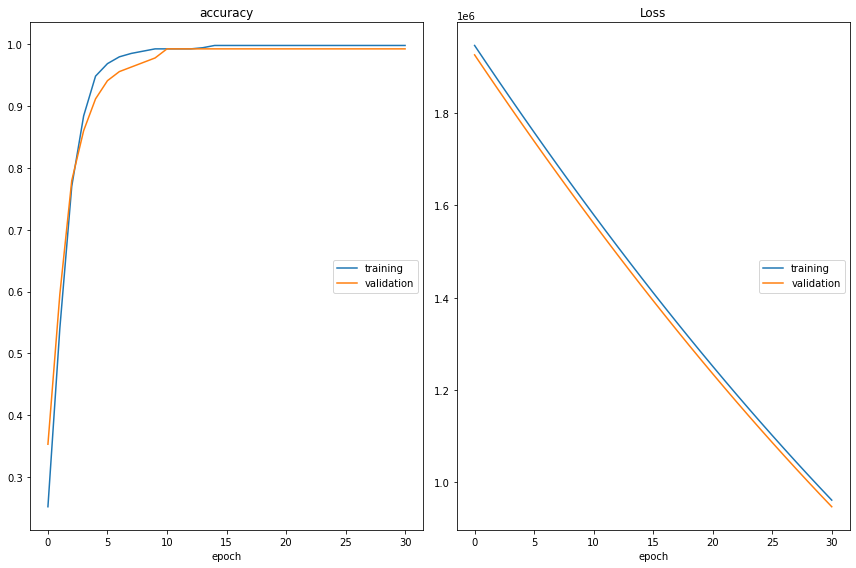

accuracy
	training         	 (min:    0.252, max:    0.998, cur:    0.998)
	validation       	 (min:    0.353, max:    0.993, cur:    0.993)
Loss
	training         	 (min: 961251.750, max: 1946908.750, cur: 961251.750)
	validation       	 (min: 946934.000, max: 1926523.250, cur: 946934.000)

Epoch 00031: val_accuracy did not improve from 0.99265


In [19]:
try:
    dnnc = load_model(filepathc)
    historyc_dict = pickle.load(open('output/trainHistoryComplete'), "rb")
    plotHistory(historyc_dict)
except:
    dnnc = get_model_complete(Xtraincomplete)
    historyc = dnnc.fit(X_train_complete_std,y_train_complete,epochs=200,
                       callbacks=[PlotLossesKeras(), checkpointc, earlystopping],
                       validation_data=(X_val_complete_std, y_val_complete), batch_size=32, 
                       shuffle=True)
    with open('output/trainHistoryComplete', 'wb') as history_complete:
        pickle.dump(historyc.history, history_complete)

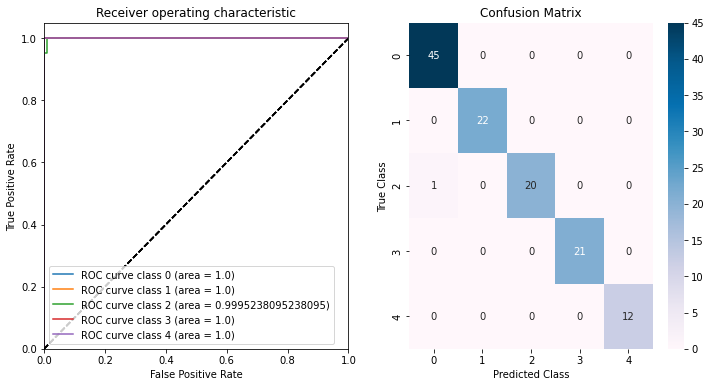

In [21]:
score_complete = calculate_average_roc_auc_score_and_plot_curves(X_test_complete_std,labelsTest, dnnc)

In [23]:
add_to_df("Deep Neural Network", "Complete", score_complete, "" )

## On Feature Selection Dataset

In [27]:
def get_model_feature(X):
    dnnf = Sequential()
    dnnf.add(Dense(60, input_dim=(X.shape[1]), activation = 'relu'))
#     dnnf.add(Dense(1200, input_dim=(X.shape[1]), activation = 'relu'))
    dnnf.add(Dense(5, activation = 'softmax'))
    dnnf.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics='accuracy')
    dnnf.summary()
    return dnnf

In [29]:
filepathf = 'output/weights_dnnf1.hdf5'
checkpointf = ModelCheckpoint(filepathf,monitor = 'val_accuracy',verbose = 1, save_best_only=True, mode='max')

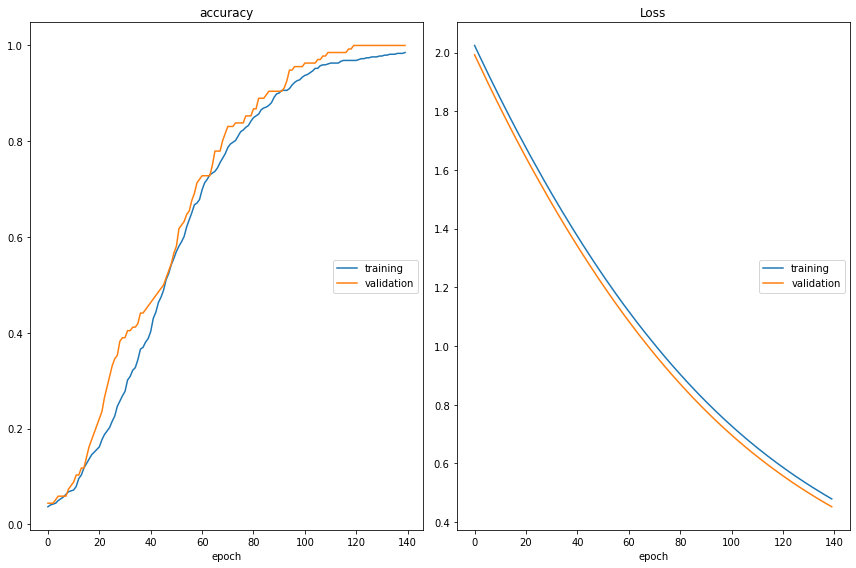

accuracy
	training         	 (min:    0.037, max:    0.985, cur:    0.985)
	validation       	 (min:    0.044, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.479, max:    2.024, cur:    0.479)
	validation       	 (min:    0.453, max:    1.992, cur:    0.453)

Epoch 00140: val_accuracy did not improve from 1.00000


In [30]:
try:
    dnnf = load_model(filepathf)
    historyf_dict = pickle.load(open('output/trainHistoryFeature'), "rb")
    plotHistory(historyf_dict)
except:
    dnnf = get_model_feature(Xtrainfeature)
    historyf = dnnf.fit(X_train_feature_std,y_train_feature,epochs=250,
                       callbacks=[PlotLossesKeras(), checkpointf, earlystopping],
                       validation_data=(X_val_feature_std, y_val_feature), batch_size=32, 
                       shuffle=True)
    with open('output/trainHistoryFeature', 'wb') as history_feat:
        pickle.dump(historyf.history, history_feat)

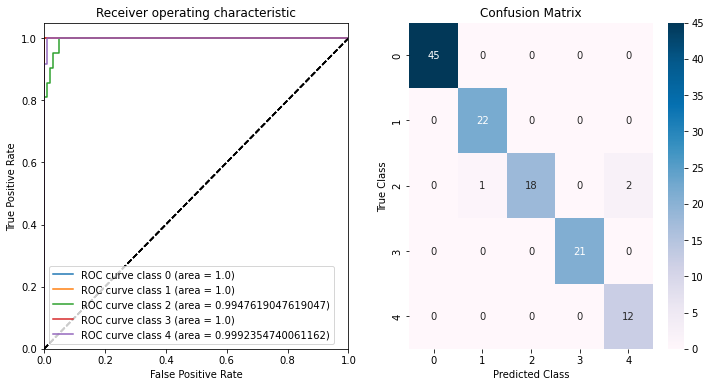

In [32]:
score_feature = calculate_average_roc_auc_score_and_plot_curves(X_test_feature_std,labelsTest, dnnf)

In [33]:
add_to_df("Deep Neural Network", "Feature Selection", score_feature, "")

## On Dimensionality Reduction Dataset

In [50]:
def get_model_dim(X):
    dnnd = Sequential()
    dnnd.add(Dense(7, input_dim=(X.shape[1]), activation = 'relu'))
    dnnd.add(Dense(7, activation = 'relu'))
    dnnd.add(Dense(5, activation = 'softmax'))
    dnnd.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')
    dnnd.summary()
    return dnnd

In [51]:
filepathd = 'output/weights_dnnd.hdf5'
checkpointd = ModelCheckpoint(filepathd,monitor = 'val_accuracy',verbose = 1, save_best_only=True, mode='max')

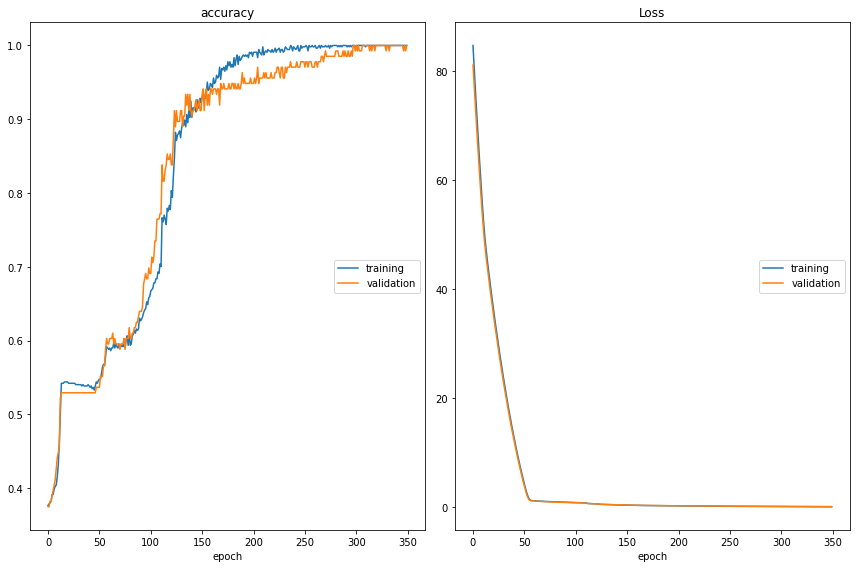

accuracy
	training         	 (min:    0.377, max:    1.000, cur:    1.000)
	validation       	 (min:    0.375, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.135, max:   84.636, cur:    0.135)
	validation       	 (min:    0.149, max:   81.039, cur:    0.149)

Epoch 00350: val_accuracy did not improve from 1.00000


In [52]:
try:
    dnnd = load_model(filepathd)
    historyd_dict = pickle.load(open('output/trainHistoryDim'), "rb")
    plotHistory(historyd_dict)
except:
    dnnd = get_model_dim(Xtrainlda)
    historyd = dnnd.fit(X_train_dim,y_train_dim,epochs=350,
                       callbacks=[PlotLossesKeras(), checkpointd],
                       validation_data=(X_val_dim, y_val_dim), batch_size=16, 
                       shuffle=True)
    with open('output/trainHistoryDim', 'wb') as history_dim:
        pickle.dump(historyd.history, history_dim)

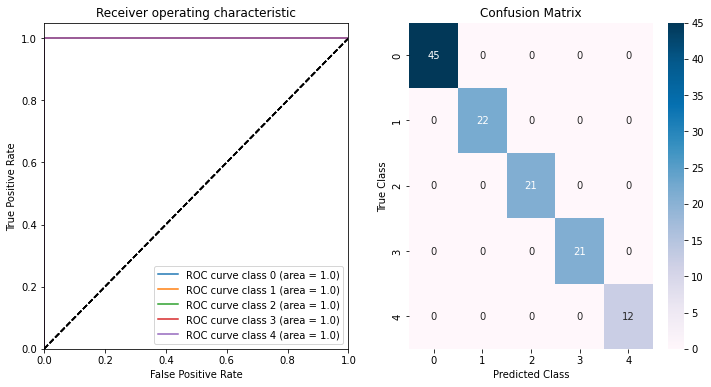

In [53]:
score_dim = calculate_average_roc_auc_score_and_plot_curves(Xtestlda,labelsTest, dnnd)

In [59]:
add_to_df("Deep Neural Network", "LDA", score_dim, "")

# Results

In [60]:
scores_df.reset_index(inplace=True)

In [62]:
scores_df.drop(columns=['index'], inplace=True)

In [63]:
scores_df

,Model Family,Dataset,ROC_AUC_SCORE,Best Params
0,Random Forest,Complete,1.000000,"{'rf__criterion': 'gini', 'rf__max_features': ..."
1,Random Forest,Feature Selection,1.000000,"{'rf__criterion': 'entropy', 'rf__max_features..."
2,Random Forest,PCA,0.999752,"{'criterion': 'entropy', 'max_features': 'sqrt..."
3,Random Forest,LDA,1.000000,"{'criterion': 'entropy', 'max_features': 'sqrt..."
4,Support Vector Classifier,Complete,1.000000,"{'svc__C': 5e-05, 'svc__kernel': 'linear'}"
5,Support Vector Classifier,Feature Selection,1.000000,"{'svc__C': 0.01, 'svc__degree': 2, 'svc__kerne..."
6,Support Vector Classifier,PCA,1.000000,"{'C': 0.0001, 'degree': 2, 'kernel': 'linear'}"
7,Support Vector Classifier,LDA,1.000000,"{'C': 0.001, 'degree': 2, 'kernel': 'linear'}"
8,Deep Neural Network,Complete,0.999917,
9,Deep Neural Network,Feature Selection,0.999015,


## Analysis

**Best Random Forest Model** : Random Forest achieves a ROC-AUC score of 1.0 on complete dataset, feature selection dataset and LDA dimensionality reduction dataset, but slightly lags behind in PCA dataset. As we discovered in week 2 and week 3, the intrinsic dimensionality of this gene expression microarray data is very low, meaning that most of the features don't add much value in the process of classification, and so are rightly termed as noise. Random Forest is good at dealing with high dimensional datasets because it only considers square root or logarithm of total number of features at a time (feature subsampling), which in our case is ~sqrt(19000) = roughly 138 features and log2(19000) = roughly 15. However, a very high number of trees must be built so as to ensure that all features are sampled in the final forest. This makes the training computationally very expensive, given that the optimal hyperaparameters are found via grid search and 5 fold cross validation. Moreover, the complete dataset is of the form p>m i.e the number of features is much higher than number of training examples. It is known that most statistical methods don't work properly in such cases of high dimensionality. Even though the results obtained are good, they can't be considered as reliable. It is considered better to reduce the dimensions of the data before building a classifer on such high dimensional dataset. Therefore we discard this model. This leaves us with two other models : The Feature Selection Dataset and the LDA Dimensionality reduction dataset. These methods have 47 and 4 number of features respectively, so they are not compuationally expensive. However, while applying LDA we lose interpretability of the model obtained, and the new features may not have real life scientific value. So, **it is best to go with Random Forest on Feature Selection Data**

**Best Support Vector Classifier** : Support Vector classifier achieved perfect ROC-AUC score on all the four algorithms. There are few interesting observations: 1. In all the 4 cases, the kernel was selected as linear, meaning that this data is linearly separable. This is not surprising as we saw in week 2 and week 3, the clusters were well separated, so a more complex kernel was not required at all. 2. The Penalty term C got selected as follows: Complete Dataset(n_features=19000): 5e-5, PCA(n_features=71):1e-4, Feature Selection Dataset(n_features=47):1e-2 and LDA(n_features=4): 1e-3. As the number of features increase, higher regularization gives good results indicating the presence of noise in the dataset, and indicating that model avoided overfitting. It is noteworthy that LDA required a higher penalty than Feature Selection dataset, which indicates noise or redundancy in the data. SVC is a fast algorithm, so there was no computational burden in any of the datasets. However, we would rule out the original dataset for the same reason as above. **Since LDA and PCA reduce interpretability of the model, here again we would go with the feature selection dataset.** 

**Best Deep Neural Network** : All 3 Neural networks achieved different scores for ROC-AUC. Going by that score alone, the Neural network performed best on LDA dataset. However, LDA model was slow in training, and showed greater fluctuations before convergence compared to other 2 models. In terms of computation, Feature Selection model was the quickest. Building a competent model on the complete dataset required a lot of parameters and hence a greater memory and gpu support, therefore it is not feasable. There are 2 misclassifications in the feature selection model, while 0 on LDA model. So, the best Deep Neural Network is LDA Model


### Best Classifier

We can judge the best model in terms of **computation requirements, ROC-AUC score, interpretability and Cross-Validation**. 


**1. Computational Requirements**: On the current dataset, both SVC and RF were quick with selected hyperparameters, while it took longer to train the neural network. 

**2. ROC-AUC Score** : All 3 models have achieved the perfect ROC-AUC score of 1.0

**3. Interpretability** : Since the SVC chosen is with linear kernel, it provides coefficient of the original features, while random forest also provides feature_importances, whereas DNN doesn't. Moreover, DNN is built on LDA dataset which furthers worsens the interpretability. 

**4.Cross-Validation Error**: Both SVC and RF were evaluated with 5 fold Cross Validation whereas DNN was evaluated using hold out set strategy, so the estimate is rather optimistic and not a true reflection of the error.

Based on the above criteria, it is clear that Neural Networks are not suitable for the given problem set. **Both Support Vector Classifier and Random Forest perform equally good**. However, the results are only valid for the current dataset, because of the No free lunch theorem. 
